In [18]:
import os
import matplotlib.pyplot as plt
import numpy as np
import mrcfile
import torch

from tomoSegmentPipeline.utils.common import read_array, write_array
from tomoSegmentPipeline.utils import setup
from cryoS2Sdrop.dataloader import singleCET_dataset, singleCET_FourierDataset

import tomopy.sim.project as proj
from tomopy.recon.algorithm import recon
import matplotlib.pyplot as plt

PARENT_PATH = setup.PARENT_PATH

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 80

def standardize(X):
    mean = X.mean()
    std = X.std()
    new_X = (X - mean) / std

    return new_X

def clip(X, low=0.005, high=0.995):
    # works with tensors =)
    return np.clip(X, np.quantile(X, low), np.quantile(X, high))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# cet_path = os.path.join(PARENT_PATH, 'data/S2SDenoising/dummy_tomograms/tomo02_dummy.mrc')
# gt_tomo_path = os.path.join(PARENT_PATH, "data/S2SDenoising/dummy_tomograms/tomo02_cryoCAREDummy.mrc")

cet_path = os.path.join(PARENT_PATH,
                        '/home/ubuntu/Thesis/data/S2SDenoising/dummy_tomograms/tomoPhantom_model14_noisyGaussPoiss.mrc')
gt_tomo_path = os.path.join(PARENT_PATH,
                        '/home/ubuntu/Thesis/data/S2SDenoising/dummy_tomograms/tomoPhantom_model14.mrc')

# cet_path = os.path.join(PARENT_PATH,
#                         'data/shrec2021/model_8/reconstruction.mrc')
# gt_tomo_path = os.path.join(PARENT_PATH,
#                         'data/shrec2021/model_8/grandmodel.mrc')



my_dataset = singleCET_FourierDataset(cet_path, 96, 0.3, gt_tomo_path=gt_tomo_path, n_bernoulli_samples=2)
tomo_data = my_dataset.data
tomo_shape = np.array(tomo_data.shape)
tomo_shape

Creating Fourier samples...
Done!


array([256, 256, 256])

In [31]:
my_dataset.fourier_samples.shape

torch.Size([40, 1, 256, 256, 256])

In [32]:
fft_data = np.fft.fftshift(np.fft.fftn(tomo_data))
logPower_Fdata = np.log(np.abs(fft_data)**2)
logPower_Fdata = standardize(clip(logPower_Fdata))

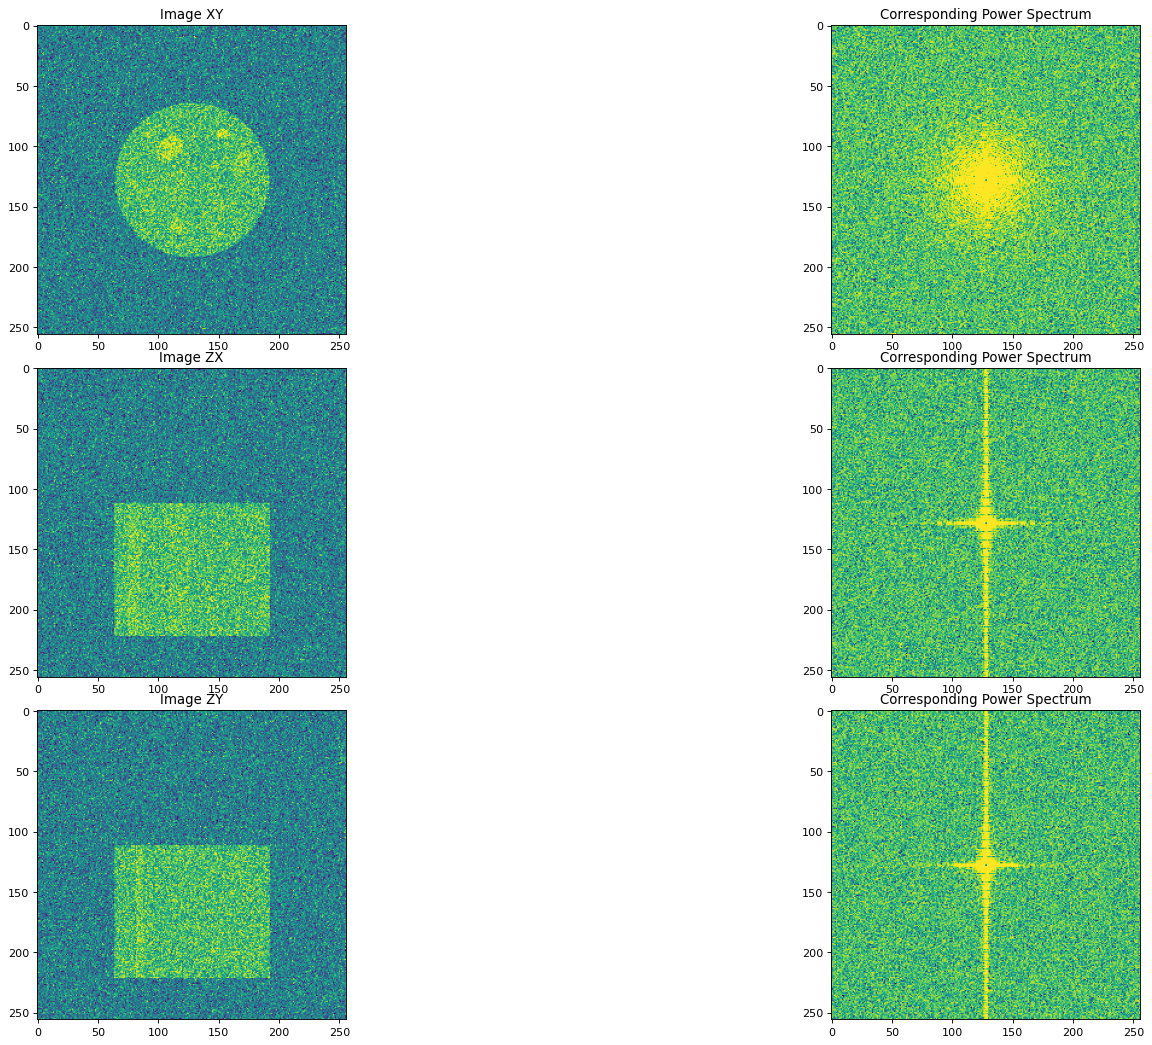

In [33]:
fig, ax = plt.subplots(3, 2, figsize=(20, 13), gridspec_kw={'height_ratios': [1, 1, 1]})  
plt.tight_layout()

ax[0][0].imshow(tomo_data[tomo_shape[0]//2])
ax[0][0].set_title('Image XY')

ax[0][1].imshow(logPower_Fdata[tomo_shape[0]//2])
ax[0][1].set_title('Corresponding Power Spectrum')

ax[1][0].imshow(tomo_data[:, tomo_shape[1]//2, :])
ax[1][0].set_title('Image ZX')

ax[1][1].imshow(logPower_Fdata[:, tomo_shape[1]//2, :])
ax[1][1].set_title('Corresponding Power Spectrum')

ax[2][0].imshow(tomo_data[:, :, tomo_shape[2]//2])
ax[2][0].set_title('Image ZY')

ax[2][1].imshow(logPower_Fdata[:, :, tomo_shape[2]//2])
ax[2][1].set_title('Corresponding Power Spectrum')


plt.show()

(array([4490776., 4184612., 3064734., 2034562., 1272370.,  757004.,
         438540.,  245091.,  134782.,  154745.]),
 array([0.0234654 , 0.62386379, 1.22426218, 1.82466057, 2.42505896,
        3.02545735, 3.62585574, 4.22625413, 4.82665252, 5.42705091,
        6.0274493 ]),
 <BarContainer object of 10 artists>)

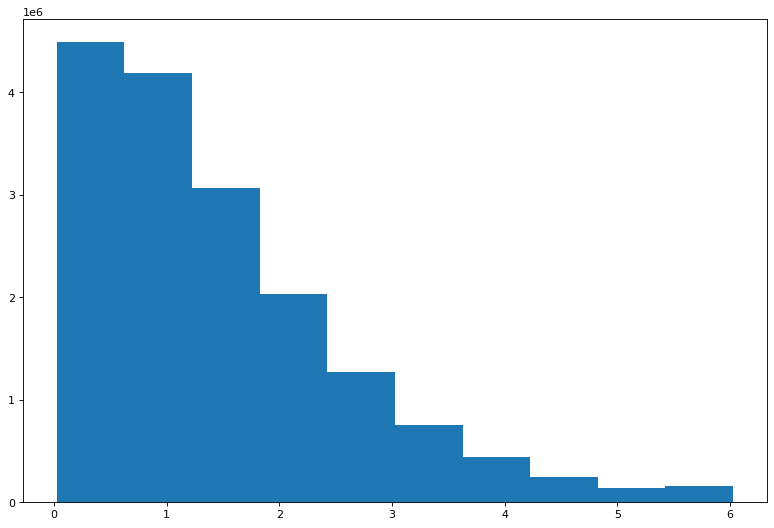

In [34]:
power_Fdata = np.exp(logPower_Fdata)
# power_Fdata = standardize(clip(power_Fdata))
plt.hist(power_Fdata.flatten())

# High power mask

In [49]:
highP_mask = my_dataset.create_bernoulliMask()[0].numpy()*(power_Fdata>np.quantile(power_Fdata, 0.5)).astype(int)
logPower_filtered = highP_mask*logPower_Fdata

fft_filtered = highP_mask*fft_data
tomo_filtered = np.fft.ifftn(np.fft.ifftshift(fft_filtered))
tomo_filtered = np.real(tomo_filtered)

(array([ 168125.,  167209.,  333658.,  649500., 1226479., 2186089.,
        3429320., 4221196., 3253336., 1142304.]),
 array([-3.75222808, -3.19737288, -2.64251768, -2.08766248, -1.53280728,
        -0.97795208, -0.42309688,  0.13175832,  0.68661352,  1.24146872,
         1.79632392]),
 <BarContainer object of 10 artists>)

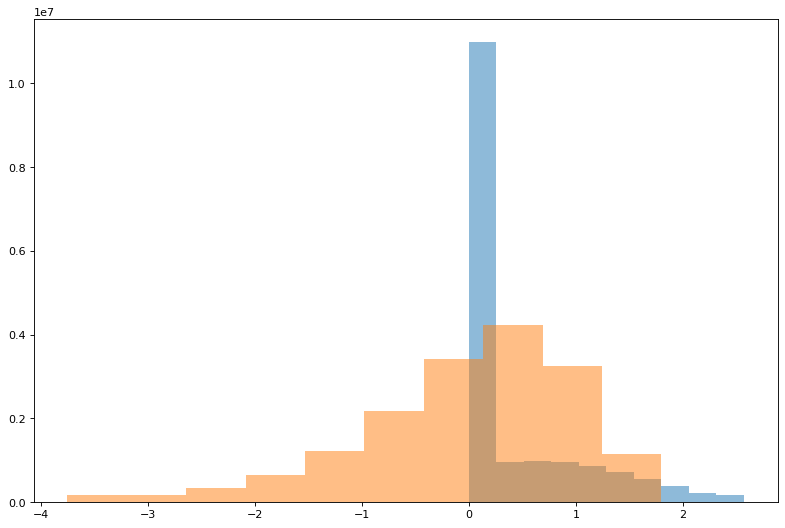

In [50]:
plt.hist(logPower_filtered.flatten(), alpha=0.5)
plt.hist(logPower_Fdata.flatten(), alpha=0.5)

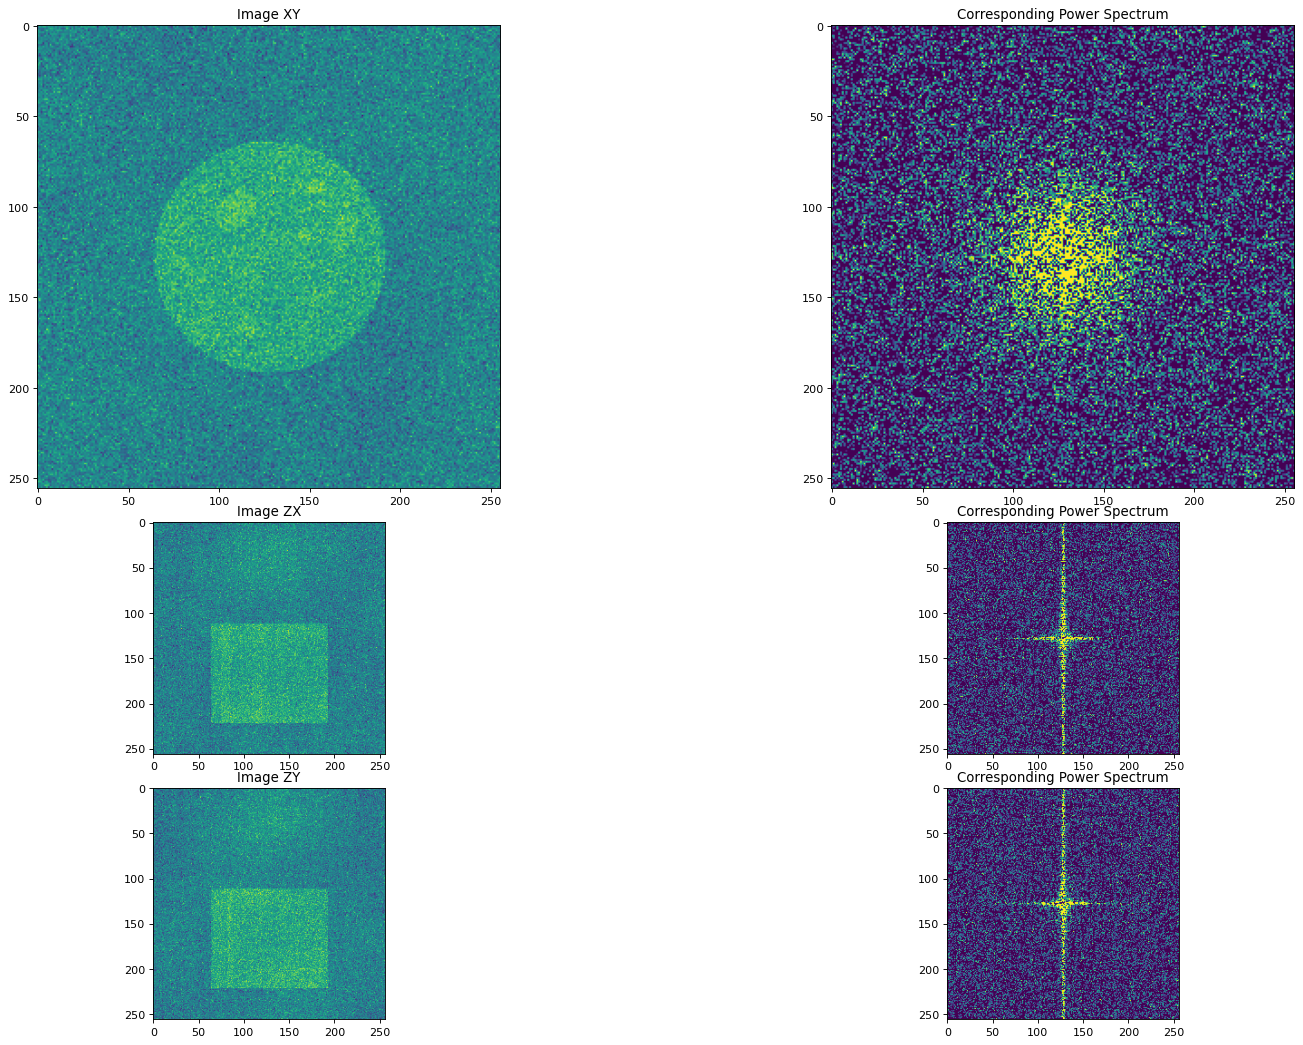

In [51]:
fig, ax = plt.subplots(3, 2, figsize=(20, 13), gridspec_kw={'height_ratios': [2, 1, 1]})  
plt.tight_layout()

ax[0][0].imshow(tomo_filtered[tomo_shape[0]//2])
ax[0][0].set_title('Image XY')

ax[0][1].imshow(logPower_filtered[tomo_shape[0]//2])
ax[0][1].set_title('Corresponding Power Spectrum')

ax[1][0].imshow(tomo_filtered[:, tomo_shape[1]//2, :])
ax[1][0].set_title('Image ZX')

ax[1][1].imshow(logPower_filtered[:, tomo_shape[1]//2, :])
ax[1][1].set_title('Corresponding Power Spectrum')

ax[2][0].imshow(tomo_filtered[:, :, tomo_shape[2]//2])
ax[2][0].set_title('Image ZY')

ax[2][1].imshow(logPower_filtered[:, :, tomo_shape[2]//2])
ax[2][1].set_title('Corresponding Power Spectrum')


plt.show()

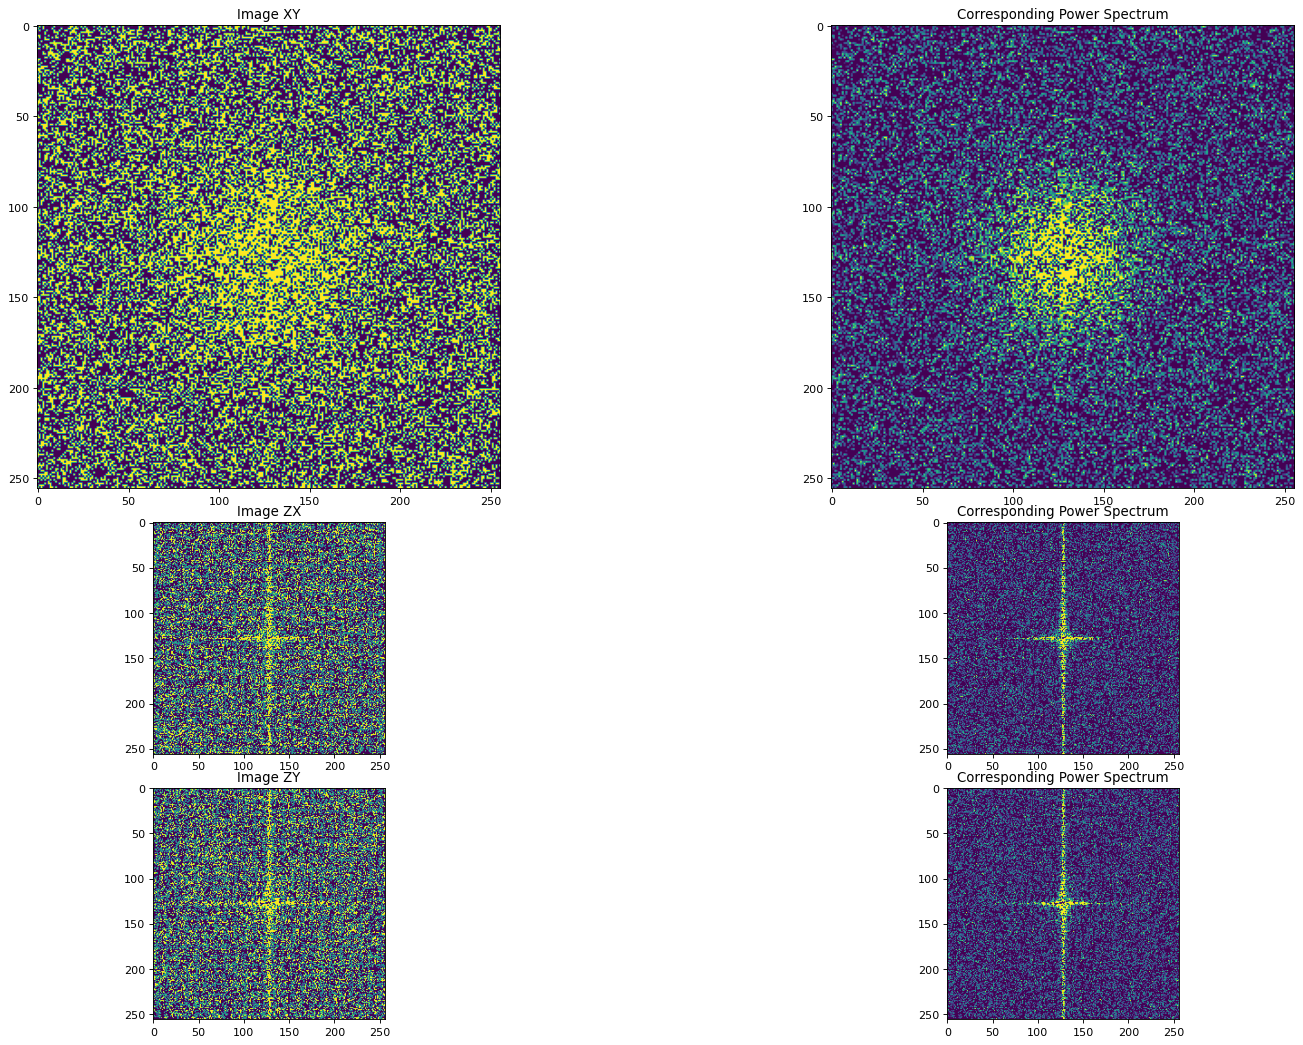

In [52]:
fig, ax = plt.subplots(3, 2, figsize=(20, 13), gridspec_kw={'height_ratios': [2, 1, 1]})  
plt.tight_layout()

ax[0][0].imshow(highP_mask[tomo_shape[0]//2])
ax[0][0].set_title('Image XY')

ax[0][1].imshow(logPower_filtered[tomo_shape[0]//2])
ax[0][1].set_title('Corresponding Power Spectrum')

ax[1][0].imshow(highP_mask[:, tomo_shape[1]//2, :])
ax[1][0].set_title('Image ZX')

ax[1][1].imshow(logPower_filtered[:, tomo_shape[1]//2, :])
ax[1][1].set_title('Corresponding Power Spectrum')

ax[2][0].imshow(highP_mask[:, :, tomo_shape[2]//2])
ax[2][0].set_title('Image ZY')

ax[2][1].imshow(logPower_filtered[:, :, tomo_shape[2]//2])
ax[2][1].set_title('Corresponding Power Spectrum')


plt.show()

# Frequency masks

In [35]:
def make_shell(inner_radius, delta_r, tomo_shape):
    """
    Creates a (3D) shell with given inner_radius and delta_r width centered at the middle of the array.
    
    """
    outer_radius = inner_radius + delta_r

    length = min(tomo_shape)
    mask_shape = len(tomo_shape) * [length]
    _shell_mask = np.zeros(mask_shape)

    # only do positive quadrant first
    for z in range(0, outer_radius + 1):
        for y in range(0, outer_radius + 1):
            for x in range(0, outer_radius + 1):
            

                r = np.linalg.norm([z, y, x])

                if r >= inner_radius and r < outer_radius:
                    zidx = z + length // 2
                    yidx = y + length // 2
                    xidx = x + length // 2

                    _shell_mask[zidx, yidx, xidx] = 1

    # first get shell for x>0
    aux = (
        np.rot90(_shell_mask, axes=(0, 1))
        + np.rot90(_shell_mask, 2, axes=(0, 1))
        + np.rot90(_shell_mask, 3, axes=(0, 1))
        + np.rot90(_shell_mask, 2, axes=(0, 2))
        + np.rot90(_shell_mask, 3, axes=(0, 2))
        + np.rot90(_shell_mask, 2, axes=(1, 2))
    )
    aux2 = _shell_mask + aux

    # finally, fill the actual shape of the tomogram with the mask
    shell_mask = np.zeros(tomo_shape)
    shell_mask[
        (tomo_shape[0] - length) // 2 : (tomo_shape[0] + length) // 2,
        (tomo_shape[1] - length) // 2 : (tomo_shape[1] + length) // 2,
        (tomo_shape[2] - length) // 2 : (tomo_shape[2] + length) // 2
    ] = aux2

    return shell_mask

In [62]:
inner = 0
outer = 40
shell_mask = make_shell(inner, outer-inner, tomo_shape)
shell_mask.shape

(256, 256, 129)

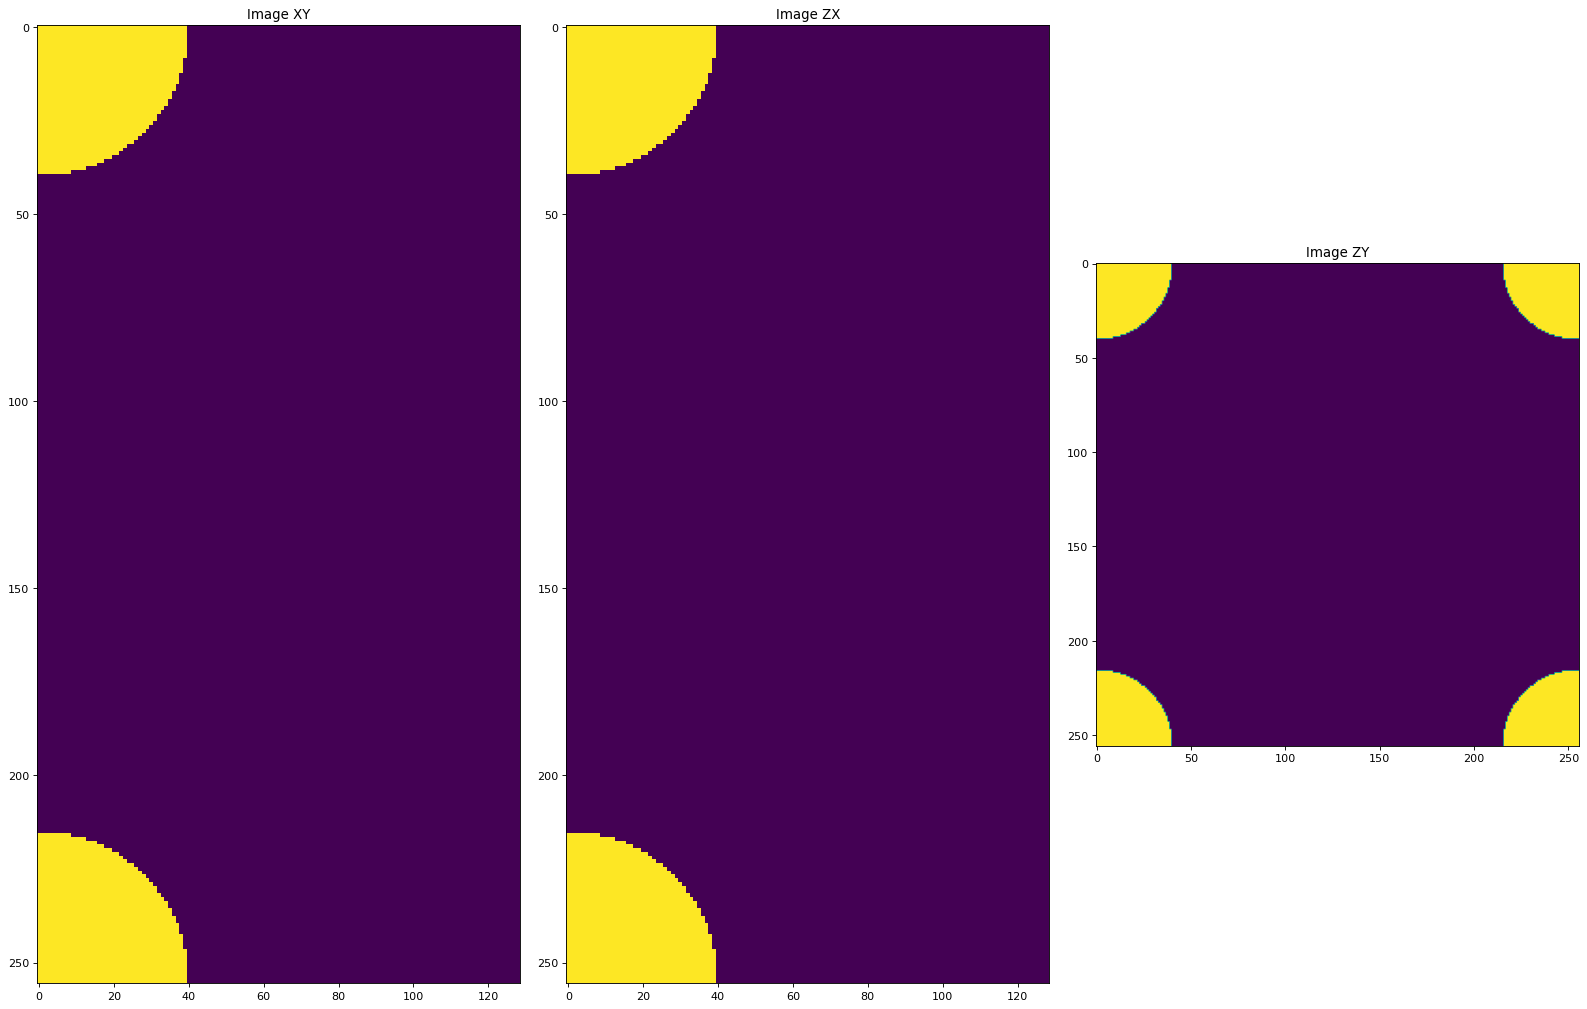

In [63]:
fig, ax = plt.subplots(1, 3, figsize=(20, 13))  
plt.tight_layout()

ax[0].imshow(shell_mask[0])
ax[0].set_title('Image XY')

ax[1].imshow(shell_mask[:, 0, :])
ax[1].set_title('Image ZX')

ax[2].imshow(shell_mask[:, :, 0])
ax[2].set_title('Image ZY')


plt.show()

In [43]:
fft_loFreq = my_dataset.create_bernoulliMask()[0].numpy()*shell_mask*fft_data
tomo_loFreqFilt = np.fft.ifftn(np.fft.ifftshift(fft_loFreq))
tomo_loFreqFilt = np.real(tomo_loFreqFilt)

logPower_loFreqFdata = np.log(np.abs(fft_loFreq)**2)
# logPower_loFreqFdata = standardize(clip(logPower_loFreqFdata))

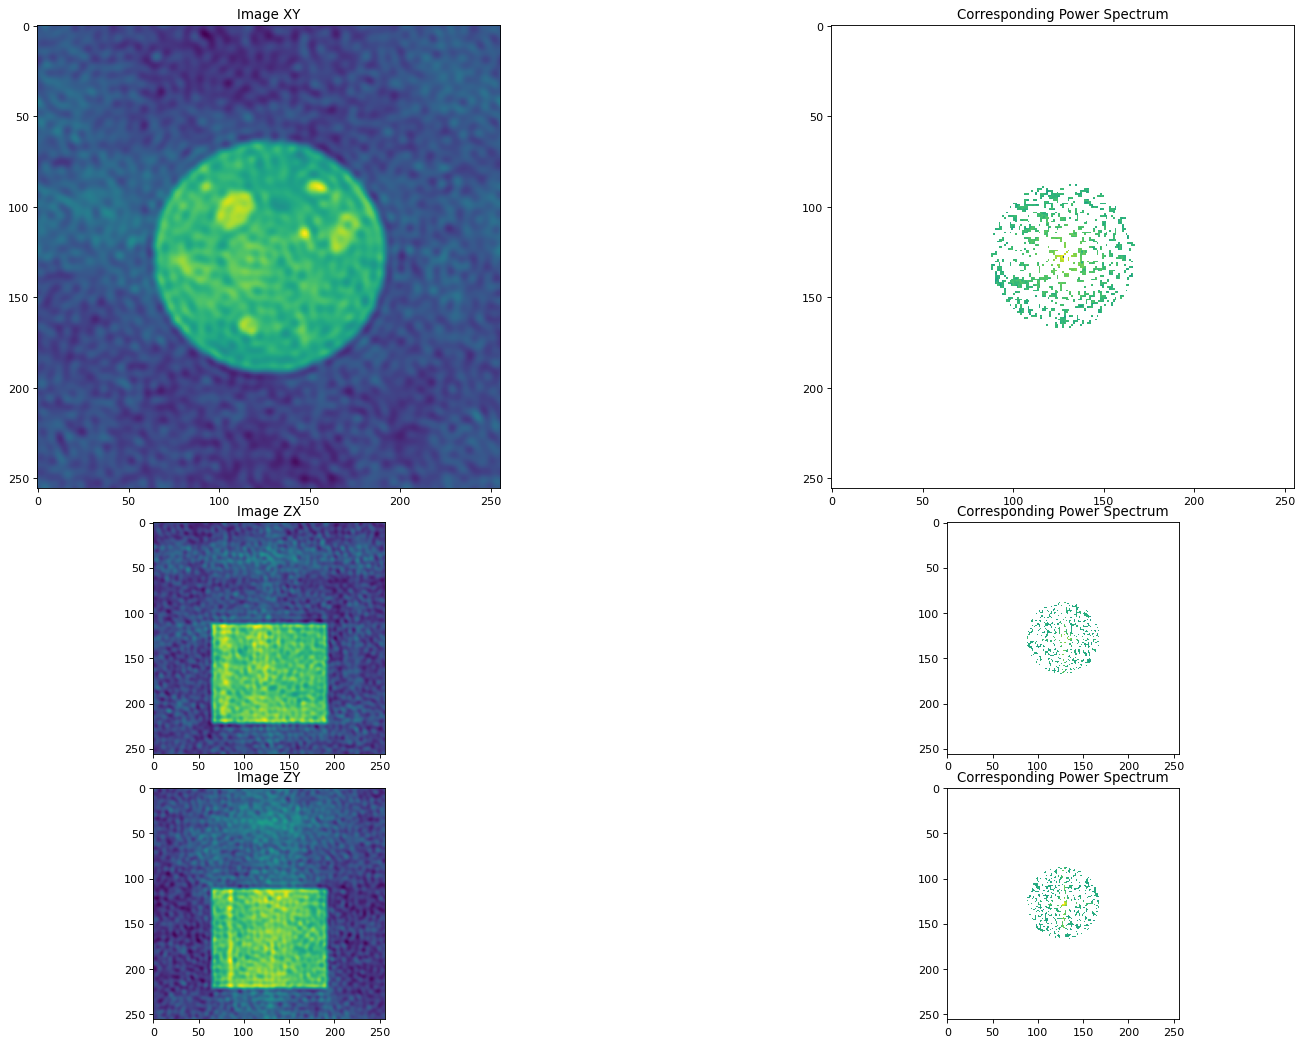

In [44]:
fig, ax = plt.subplots(3, 2, figsize=(20, 13), gridspec_kw={'height_ratios': [2, 1, 1]})  
plt.tight_layout()

ax[0][0].imshow(tomo_loFreqFilt[tomo_shape[0]//2])
ax[0][0].set_title('Image XY')

ax[0][1].imshow(logPower_loFreqFdata[tomo_shape[0]//2])
ax[0][1].set_title('Corresponding Power Spectrum')

ax[1][0].imshow(tomo_loFreqFilt[:, tomo_shape[1]//2, :])
ax[1][0].set_title('Image ZX')

ax[1][1].imshow(logPower_loFreqFdata[:, tomo_shape[1]//2, :])
ax[1][1].set_title('Corresponding Power Spectrum')

ax[2][0].imshow(tomo_loFreqFilt[:, :, tomo_shape[2]//2])
ax[2][0].set_title('Image ZY')

ax[2][1].imshow(logPower_loFreqFdata[:, :, tomo_shape[2]//2])
ax[2][1].set_title('Corresponding Power Spectrum')


plt.show()

# Combine masks

In [15]:
fft_loFreq = highP_mask*shell_mask*fft_data
tomo_loFreqFilt = np.fft.ifftn(np.fft.ifftshift(fft_loFreq))
tomo_loFreqFilt = np.real(tomo_loFreqFilt)

logPower_loFreqFdata = np.log(np.abs(fft_loFreq)**2)
# logPower_loFreqFdata = standardize(clip(logPower_loFreqFdata))

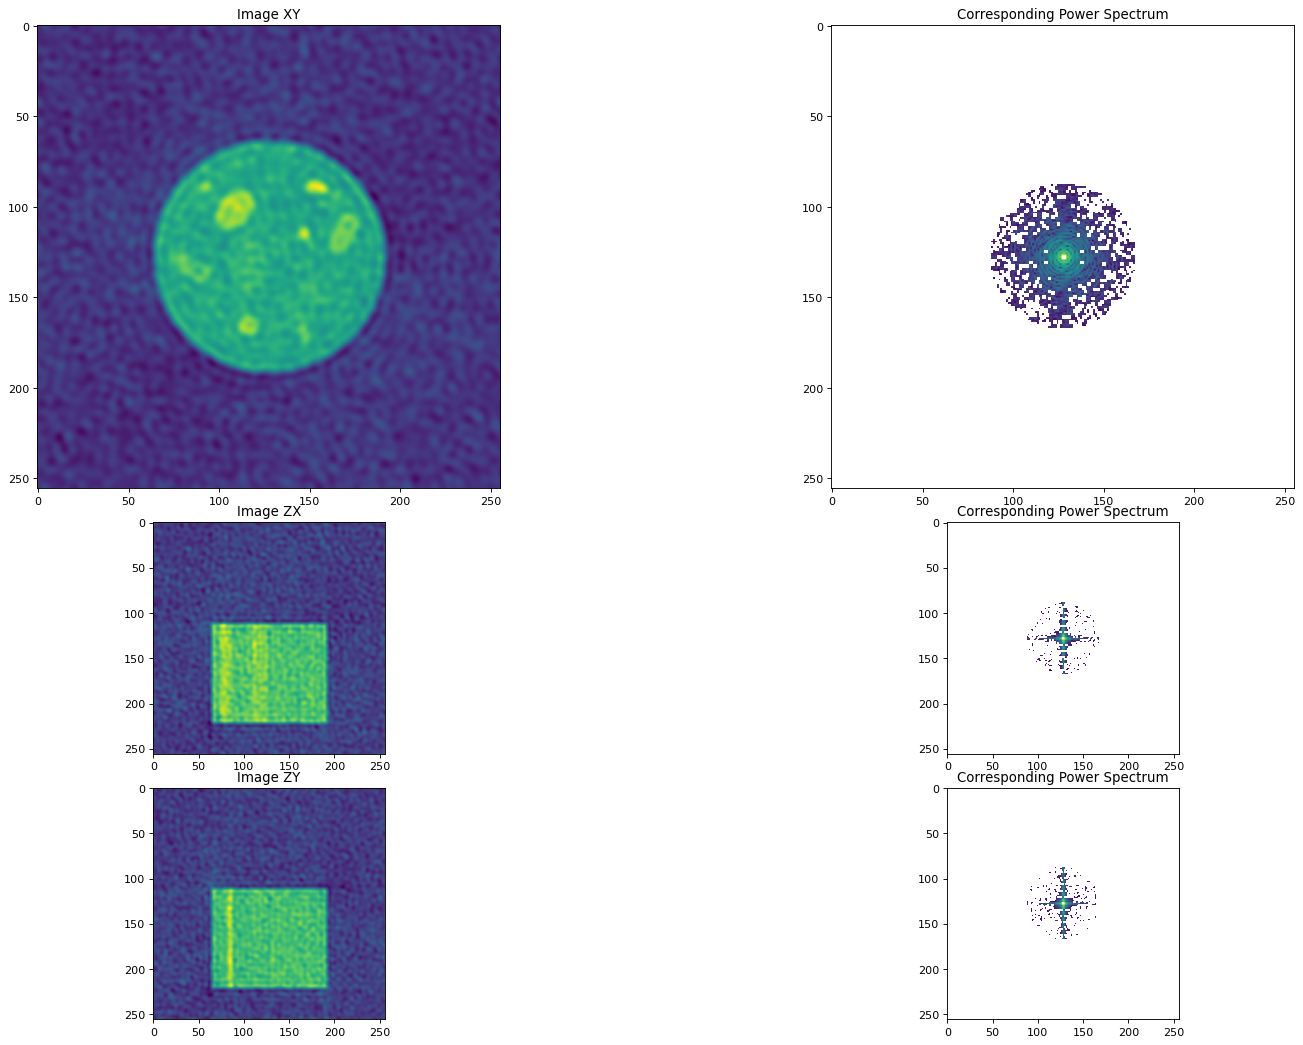

In [16]:
fig, ax = plt.subplots(3, 2, figsize=(20, 13), gridspec_kw={'height_ratios': [2, 1, 1]})  
plt.tight_layout()

ax[0][0].imshow(tomo_loFreqFilt[tomo_shape[0]//2])
ax[0][0].set_title('Image XY')

ax[0][1].imshow(logPower_loFreqFdata[tomo_shape[0]//2])
ax[0][1].set_title('Corresponding Power Spectrum')

ax[1][0].imshow(tomo_loFreqFilt[:, tomo_shape[1]//2, :])
ax[1][0].set_title('Image ZX')

ax[1][1].imshow(logPower_loFreqFdata[:, tomo_shape[1]//2, :])
ax[1][1].set_title('Corresponding Power Spectrum')

ax[2][0].imshow(tomo_loFreqFilt[:, :, tomo_shape[2]//2])
ax[2][0].set_title('Image ZY')

ax[2][1].imshow(logPower_loFreqFdata[:, :, tomo_shape[2]//2])
ax[2][1].set_title('Corresponding Power Spectrum')


plt.show()